# Cifar 10: revisit with pytorch + fastai

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10")
TRAIN = PATH/'train'
TEST = PATH/'test'

sz=32

In [3]:
# class AdaptiveConcatPool2d(nn.Module):
#     def __init__(self, sz=None):
#         super().__init__()
#         sz = sz or (1,1)
#         self.ap = nn.AdaptiveAvgPool2d(sz)
#         self.mp = nn.AdaptiveMaxPool2d(sz)
#     def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# class Lambda(nn.Module):
#     def __init__(self, f): super().__init__(); self.f=f
#     def forward(self, x): return self.f(x)

# class Flatten(nn.Module):
#     def __init__(self): super().__init__()
#     def forward(self, x): return x.view(x.size(0), -1)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

# Construct dataset
With torchvision data loader + data aug from low level torchvision + low level dataset from fastai

In [4]:

def get_data_loader(bs,path,shuffle=False,is_aug=False,num_workers=4):
    tfms_list = [transforms.ToTensor(),
                 transforms.Normalize(tuple(stats[0]),tuple(stats[1]))]
    aug_list = [transforms.RandomCrop(sz,padding=4),
               transforms.RandomHorizontalFlip()]
    tfms = transforms.Compose(tfms_list)
    aug_tfms = transforms.Compose(aug_list+tfms_list)
    
    ds = datasets.ImageFolder(path,aug_tfms if is_aug else tfms)
    dl = torch.utils.data.DataLoader(ds,batch_size=bs,shuffle=shuffle,
                                    num_workers = num_workers,pin_memory=True)
    return dl
def get_data(bs):
    trn_dl = get_data_loader(bs,TRAIN,True,True)
    val_dl = get_data_loader(bs,TEST)
    aug_dl = get_data_loader(bs,TRAIN,False,True)
    
    # use model data to encapsulate data loaders and datasets for training,val and test
    data = ModelData(PATH,trn_dl,val_dl)
    data.aug_dl = aug_dl
    data.sz=sz
    return data

Testing output of data loader

In [5]:
from matplotlib import pyplot as plt,cm
def show_img(im,figsize=None,ax=None):
    if not ax: fig,ax = plt.subplots(figsize = figsize)
    ax.imshow(im)
    return ax

def denorm_img(im):
    im = (im*stats[1] + stats[0])
    im = im.astype(np.float32)
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return np.clip(im,0,1)

In [7]:
# check validation data
data = get_data(12)
X,y = to_np(next(iter(data.val_dl)))
X=np.moveaxis(X,1,3)

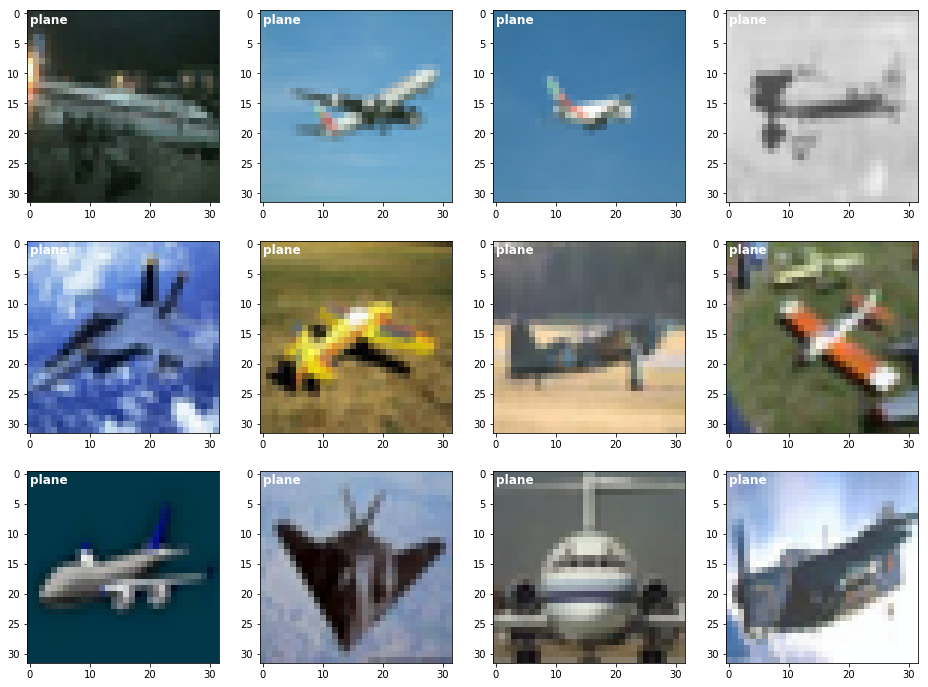

In [8]:
fig,axes=plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    ax=show_img(denorm_img(X[i]),ax=ax)
    _=ax.text(0,0, classes[y[i]],
        verticalalignment='top', color='white', fontsize=12, weight='bold')

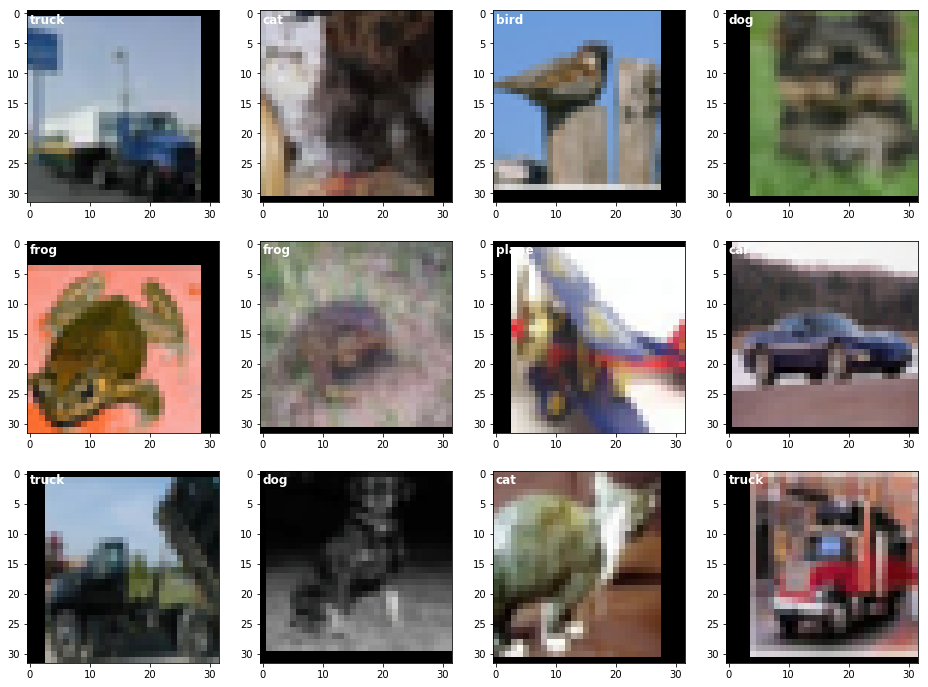

In [9]:
# check training data with augmentation
data = get_data(12)
X,y = to_np(next(iter(data.trn_dl)))
X=np.moveaxis(X,1,3)

fig,axes=plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    ax=show_img(denorm_img(X[i]),ax=ax)
    _=ax.text(0,0, classes[y[i]],
        verticalalignment='top', color='white', fontsize=12, weight='bold')

# Model

In [18]:
def accuracy_cpu(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds.cpu()==targs).float().mean()
def get_learner(arch, bs):
    learn = ConvLearner.from_model_data(arch.cuda(), get_data(bs))
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy_cpu]
    return learn


In [19]:
def get_TTA_accuracy(learn):
    log_preds, targs = learn.TTA()
    preds = np.exp(log_preds)
    # combining the predictions across augmented and non augmented inputs
#     preds = 0.6 * preds[0] + 0.4 * (preds[1:].sum(0))
    preds = np.mean(preds,0)
    return accuracy_np(preds, targs)

In [8]:
learn = get_learner(wrn_22(), 512)

In [15]:
learn

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): BasicBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (1): ReLU(inplace)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [14]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 432)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 96, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 1536)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 96, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 13824)]))

In [11]:
from IPython.core.debugger import set_trace

epoch      trn_loss   val_loss   accuracy                 
    0      2.084833   12999.3872 0.1       


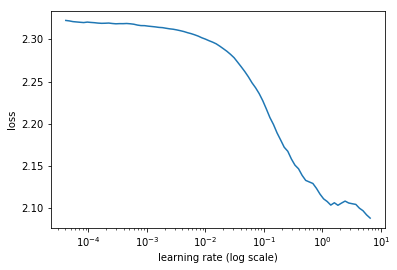

In [16]:
# learn = get_learner(wrn_22(), 512)

learn.lr_find(wds=1e-4)
learn.sched.plot(n_skip_end=1)

In [17]:
%time learn.fit(1.5, 1, wds=1e-4, cycle_len=30, use_clr_beta=(15, 10, 0.95, 0.85));


# use_clr_beta= (div,pct,max_mon,min_mon)
# div: by how much do we want to divide the maximum lr. I.e min_lr = max_lr/div
# pct: what percentage of epochs should be left at the end for the final annealing. lr will be decreased from min_lr until it reaches 0
# max_mom: the maximum momentum
# min_mom: the minimum momentum


epoch      trn_loss   val_loss   accuracy                 
    0      1.505244   1.772088   0.4522    
    1      1.096961   1.426475   0.5357                   
    2      0.877127   1.106356   0.6306                    
    3      0.712277   0.861062   0.7116                    
    4      0.612389   0.73636    0.7513                    
    5      0.539415   0.702612   0.7686                    
    6      0.489387   0.678942   0.7705                    
    7      0.447569   0.570152   0.806                     
    8      0.413818   0.792698   0.7562                    
    9      0.384101   0.632658   0.7955                    
    10     0.367036   0.787697   0.7619                    
    11     0.353256   1.008922   0.7182                    
    12     0.338451   0.702541   0.7789                    
    13     0.319884   1.664682   0.6666                    
    14     0.303832   0.581232   0.8212                    
    15     0.2885     0.933403   0.7495                   

[array([0.23722]), 0.9369]

In [ ]:
# get_TTA_accuracy(learn)

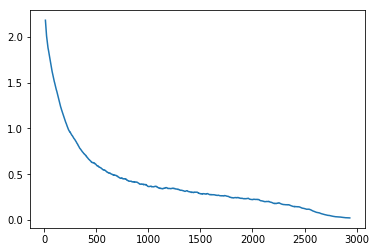

In [19]:
learn.sched.plot_loss()

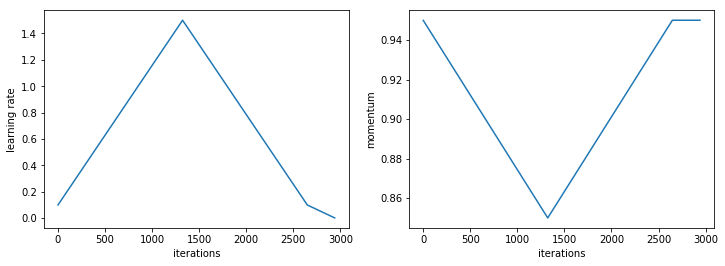

In [20]:
learn.sched.plot_lr()

(Taken from <https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy>)

- 1 cycle policy: a method of regularization that results in faster + more efficient training

Do 1 cycle with 2 steps of equal lenghts. One from min lr to max lr and then go back to min lr.
Maximum lr should be picked from learning rate finder. Min lr can be 1/10 of max lr. After approaching to min lr, we can allow lr to decrease more (for finetuning after loss is minimzed)


Why? Start with low lr -> warm-up the training. Reaching maximum in the middle of learning rate can regularize the process and preven network from overfitting (high lr prevents model to be stuck in steep local minimum and help model to reach a minimum that is flatter). With this method, we can even try a higher lr than the one recommended by lr finder. Be aware that loss can reach higher when reaching this high lr. Increase # of epochs in cycle  (increase warm up time) can help.

- Momentum: decreasing SGD momentum in the same fashion at increasing lr can led to better results. Reminder: momentum works by adding average of previous gradients to the weight-update function, in addition to gradient term. The idea is 'keep going in the previous direction like before, but steer it a little bit in current direction'
```
exp_current_grad_w = exp_prev_grad_w * 0.9 + 0.1 * current_grad_w 
w = w - learning_rate * exp_current_grad_w
```
(momentum is .9 in this case)

Why decreasing momentum? In the middle of cycle where lr is high, we want sgd to go in new directions and find a flatter loss area. We want model to take a bigger jump so we will tell model to disregard previous direction a little bit more and follow the new direction given by current weight gradient.

Recommended values for min and max momentum are .85 and .95


- Tuning weight decay (L2 reg) and batch size: 

Run learning rate finder for few values of weight decay and pick the max wd that allows max learning rate.
Also, batch size should be set to the highest possible value to fit in memory

One thing to not forget is: rerun learning rate finder when deciding to repick a strategy, especially one with aggressive learning rate close to maximum possible value


# Using fastai model data

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32

In [10]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

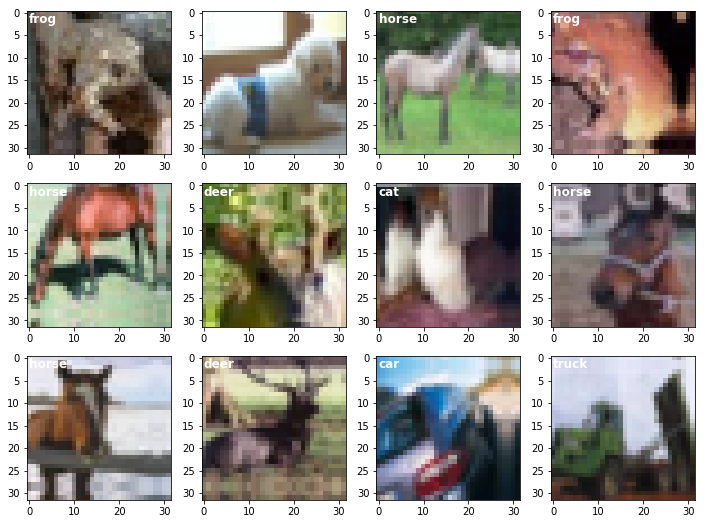

In [12]:
# check data augmentation from fastai

X,y = to_np(next(iter(data.trn_dl)))
X=np.moveaxis(X,1,3)

fig,axes=plt.subplots(3, 4, figsize=(12, 9))
for i,ax in enumerate(axes.flat):
    ax=show_img(denorm_img(X[i]),ax=ax)
    _=ax.text(0,0, classes[y[i]],
        verticalalignment='top', color='white', fontsize=12, weight='bold')

As we can see, RandomCrop in fastai library replaces black borders (results from cropping) with reflection padding. This results in slightly better result in the same # of epochs (shown below)

In [13]:
m = wrn_22()

In [8]:
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.5

epoch      trn_loss   val_loss   accuracy                 
    0      2.108049   16348.569456 0.1       



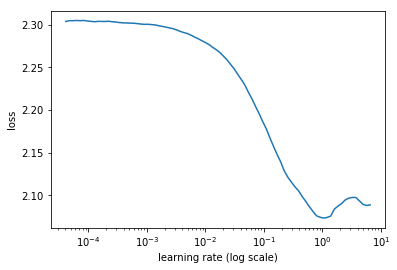

In [9]:
learn.lr_find(wds=1e-4)
learn.sched.plot(n_skip_end=1)

In [10]:
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                 
    0      1.455183   1.557729   0.4641    
    1      1.076066   1.21643    0.6055                   
    2      0.829559   0.969551   0.6625                    
    3      0.688541   0.812705   0.7064                    
    4      0.584266   0.724623   0.7598                    
    5      0.497311   0.618685   0.7941                    
    6      0.454566   0.716841   0.7737                    
    7      0.432187   0.90871    0.7138                    
    8      0.392463   0.498749   0.8276                    
    9      0.362629   0.51304    0.8276                    
    10     0.350097   0.549115   0.8167                    
    11     0.343084   0.532653   0.8249                    
    12     0.316659   0.660743   0.7992                    
    13     0.309278   0.574523   0.8106                    
    14     0.291019   0.51533    0.8287                    
    15     0.271144   0.451679   0.8517                   

[array([0.21874]), 0.9371999993324279]

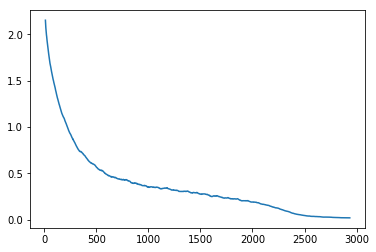

In [11]:
learn.sched.plot_loss()

# Fixing weight decay problem for Adam optimizer (AdamW)

AdamW is another way to use L2 regularization in Adam.

For example, in SGD + momentum, the original way to use L2 reg is

```
moving_avg = alpha * moving_avg + (1-alpha) * (w.grad + wd*w)
w = w - lr * moving_avg
```
The regularization part is lr * (1-alpha) * wd * w. It's the same in Adam: we add this wd * w to the moving gradients before using it to update weight


The other way, which might perform better:
```
moving_avg = alpha * moving_avg + (1-alpha) * w.grad 
w = w - lr * moving_avg - lr * wd * w
```
The regularization part is now just lr * wd * w. In this case, we add wd * w AFTER we are done with moving average gradient computation.

## Original L2 regularization (with Adam)

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32

tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [16]:
m = wrn_22()

learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
wd=1e-4
# lr=0.5

In [17]:
learn.save('init')

In [18]:
learn.lr_find(wds=wd)

epoch      trn_loss   val_loss   accuracy                 
    0      4.832362   162502401798.9632 0.1       



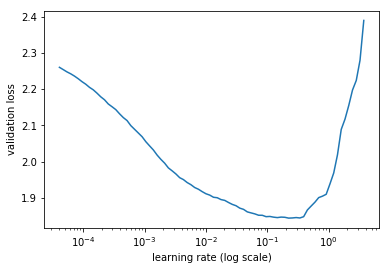

In [19]:
learn.sched.plot()

In [22]:
lr= 5e-2
learn.load('init')
%time learn.fit(lr, 1, wds=wd, cycle_len=20, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                 
    0      1.524591   1.680072   0.424     
    1      1.261259   1.683181   0.42                     
    2      1.091048   2.40295    0.3271                   
    3      0.960361   1.221154   0.5621                    
    4      0.869624   1.190117   0.6084                    
    5      0.808204   2.683078   0.4671                    
    6      0.78146    2.379599   0.4839                    
    7      0.778203   3.761832   0.3592                    
    8      0.743606   3.443127   0.3098                    
    9      0.701351   2.167052   0.3973                    
    10     0.672105   1.314445   0.6036                    
    11     0.632917   1.382522   0.5877                    
    12     0.596093   0.778733   0.7362                    
    13     0.541248   0.590808   0.7945                    
    14     0.503198   0.559601   0.8114                    
    15     0.452479   0.474616   0.8395                    

[array([0.4241]), 0.8553999996185303]

In [23]:
val_l2 = learn.sched.val_losses
met_l2 = learn.sched.rec_metrics

## AdamW

epoch      trn_loss   val_loss   accuracy                 
    0      4.468413   739202053.9392 0.1       



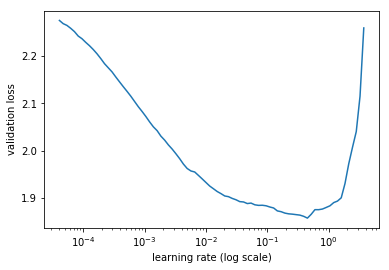

In [11]:
learn.load('init')
learn.lr_find(wds=wd, use_wd_sched=True)
learn.sched.plot()

In [12]:
lr= 6e-2
learn.load('init')
%time learn.fit(lr, 1, wds=wd, cycle_len=20, use_clr_beta=(20,20,0.95,0.85),use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                 
    0      1.637287   3.103998   0.2825    
    1      1.381676   2.223319   0.3913                   
    2      1.185193   3.695487   0.3431                   
    3      1.037234   2.326353   0.4495                   
    4      0.941706   1.312193   0.5965                    
    5      0.847657   1.036249   0.6499                    
    6      0.76819    1.230449   0.6299                    
    7      0.704031   1.204238   0.6397                    
    8      0.632149   1.053753   0.6762                    
    9      0.554437   0.63188    0.7912                    
    10     0.490691   0.729738   0.7722                    
    11     0.426254   0.499812   0.8354                    
    12     0.364521   0.509126   0.8279                    
    13     0.312675   0.398768   0.8706                    
    14     0.268297   0.370687   0.8755                    
    15     0.224296   0.320776   0.8958                    


[array([0.31534]), 0.9030000003814698]

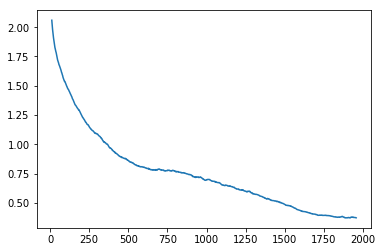

In [25]:
learn.sched.plot_loss()

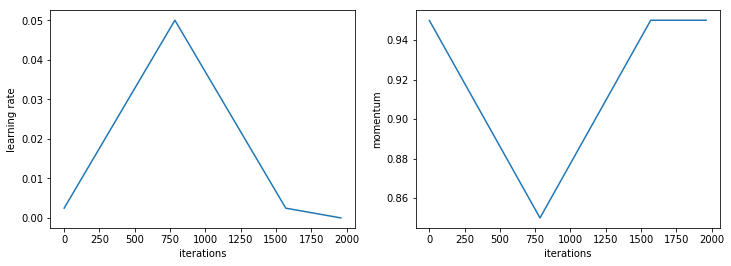

In [26]:
learn.sched.plot_lr()

In [13]:
val_wd = learn.sched.val_losses
met_wd = learn.sched.rec_metrics

In [14]:
# TTA prediction on validation set
def accuracy_with_TTA(learn):
    preds, targs = learn.TTA()
    probs = np.mean(np.exp(preds),0)
    return accuracy_np(probs, targs)
accuracy_with_TTA(learn)

0.9069

## Comparing 2 approaches

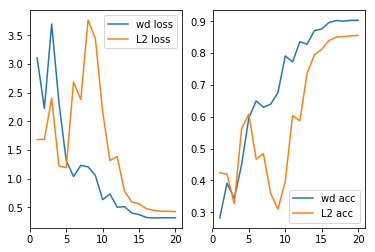

In [24]:
epochs = list(range(1,21))
fig, ax = plt.subplots(1,2)
ax[0].plot(epochs, val_wd, label='wd loss')
ax[0].plot(epochs, val_l2, label='L2 loss')
ax[0].legend(loc='upper right')

ax[1].plot(epochs, met_wd, label='wd acc')
ax[1].plot(epochs, met_l2, label='L2 acc')
ax[1].legend(loc='lower right')

plt.show()